## Telecommunication Sector Model

In [1]:
#%pip install quandl

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_error as mae
from functools import reduce


### Load target variable data

In [3]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('PE_daily_normalized_tele.csv')
pe_ratio.head()

,Dates,PE
0,Aug-24-2001,21.84x
1,Aug-27-2001,21.54x
2,Aug-28-2001,21.34x
3,Aug-29-2001,21.16x
4,Aug-30-2001,21.09x


In [4]:
# load telecommunication index price -- also from Capital IQ
price = pd.read_csv('daily_price_tele.csv')
price.head()

,Dates,Value
0,Aug-01-2001,198.68
1,Aug-02-2001,195.27
2,Aug-03-2001,193.28
3,Aug-06-2001,191.48
4,Aug-07-2001,191.19


In [5]:
# load 10 year treasury rate
quandl.ApiConfig.api_key = "_hLYTCZrYi9hepbQPNou"

treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [6]:
# rename, change type
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date", "PE" : "PE"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

pe_ratio['PE'] = pe_ratio['PE'].str.rstrip('x')
pe_ratio['PE'] = pd.to_numeric(pe_ratio['PE'])
pe_ratio.head()

,PE
Date,
2001-08-24,21.84
2001-08-27,21.54
2001-08-28,21.34
2001-08-29,21.16
2001-08-30,21.09


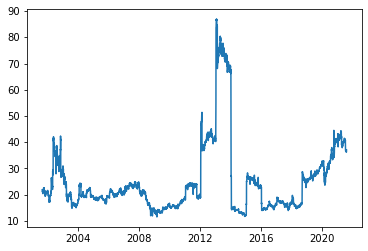

In [7]:
plt.plot(pe_ratio.PE)

In [8]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')

price.head()

,Price
Date,
2001-08-01,198.68
2001-08-02,195.27
2001-08-03,193.28
2001-08-06,191.48
2001-08-07,191.19


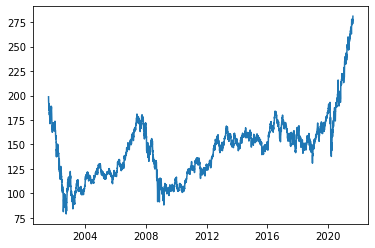

In [9]:
plt.plot(price.Price)

In [10]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


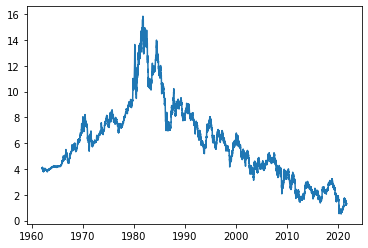

In [11]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [12]:
joined = pe_ratio.join(price).join(treasury)
joined.head()

,PE,Price,treasury_rate
Date,,,
2001-08-24,21.84,183.24,4.93
2001-08-27,21.54,180.65,4.94
2001-08-28,21.34,179.19,4.85
2001-08-29,21.16,177.58,4.78
2001-08-30,21.09,176.92,4.79


In [13]:
joined['month'] = joined.index.month
joined['year'] = joined.index.year

joined = joined.groupby([joined.year, joined.month]).mean()
joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      21.358333  179.221667       4.856667
     9      21.543333  180.474000       4.748667
     10     21.277391  177.617391       4.566818
     11     20.492381  167.864762       4.651500
     12     20.719000  167.026000       5.087500

In [14]:
joined = joined.reset_index()
joined['date'] = pd.to_datetime(joined[['year', 'month']].assign(DAY=1))
joined = joined.set_index('date')
joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667
2001-09-01,2001,9,21.543333,180.474000,4.748667
2001-10-01,2001,10,21.277391,177.617391,4.566818
2001-11-01,2001,11,20.492381,167.864762,4.651500
2001-12-01,2001,12,20.719000,167.026000,5.087500


In [15]:
joined['earnings'] = joined.Price / joined.PE
joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667,8.391182
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489


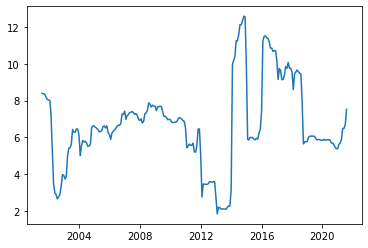

In [16]:
plt.plot(joined.earnings)

In [17]:
joined['earnings_change'] = joined.earnings.pct_change()
display(joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change
date,,,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667,8.391182,NaN
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255,-0.001660
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705,-0.003527
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569,-0.018704
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489,-0.015880
...,...,...,...,...,...,...,...
2021-04-01,2021,4,42.774500,251.382000,1.628000,5.876913,0.031792
2021-05-01,2021,5,39.058500,253.229000,1.621000,6.483326,0.103186
2021-06-01,2021,6,40.197368,260.633684,1.524211,6.483849,0.000081


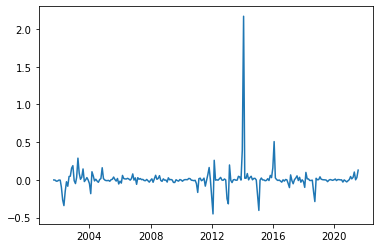

In [18]:
plt.plot(joined.earnings_change)

In [19]:
joined['target'] = joined.earnings_change - ((1 + joined.treasury_rate/100)**(1/12) - 1)
joined = joined.dropna()
joined.head()

,year,month,PE,Price,treasury_rate,earnings,earnings_change,target
date,,,,,,,,
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255,-0.001660,-0.005533
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705,-0.003527,-0.007256
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569,-0.018704,-0.022500
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489,-0.015880,-0.020024
2002-01-01,2002,1,20.239048,162.613810,5.035714,8.034657,-0.003328,-0.007431


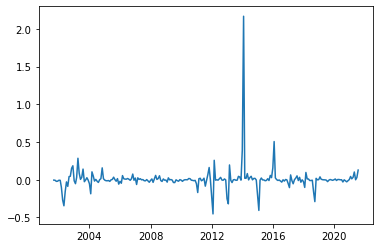

In [20]:
plt.plot(joined.target)

In [21]:
target = joined['target'].to_frame()
target.head()

,target
date,
2001-09-01,-0.005533
2001-10-01,-0.007256
2001-11-01,-0.022500
2001-12-01,-0.020024
2002-01-01,-0.007431


## Load exogenous Variables

In [22]:
def get_df_name(df):
    # grabs name of dataframe to be used as variable name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def var_change(df):
    df_name = get_df_name(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.set_index('Date')

    df = df.rename(columns = {'Value':df_name}).drop(columns = ['year', 'month'])

    df_mom_ch = df.rename(columns = {df_name : df_name + '_mom_ch'})
    df_mom_ch = df_mom_ch[df_name + '_mom_ch'].diff(1)/ df_mom_ch[df_name + '_mom_ch']

    df_yoy_ch = df.rename(columns = {df_name : df_name + '_yoy_ch'})
    df_yoy_ch = df_yoy_ch[df_name + '_yoy_ch'].diff(12)/ df_yoy_ch[df_name + '_yoy_ch']

    df_final = pd.DataFrame(df_mom_ch).join(df_yoy_ch).join(df)
    
    return df_final

## Load Quandl indicators

In [23]:
# CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
cpi = quandl.get('FRED/CPIAUCSL')
cpi.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [24]:
# WPU117601 - Producer Price Index by Commodity: Machinery and Equipment: Telephone and Wireline Data Networking Equipment
ppi_w = quandl.get('FRED/WPU117601')
ppi_w.head()

,Value
Date,
1985-12-01,100.0
1986-01-01,101.1
1986-02-01,101.1
1986-03-01,101.4
1986-04-01,101.4


In [25]:
# ITMTCIM133S - U.S. Imports of Services: Telecommunications, Computer, and Information Services
imp = quandl.get('FRED/ITMTCIM133S')
imp.head()

,Value
Date,
1999-01-01,1252.0
1999-02-01,1252.0
1999-03-01,1252.0
1999-04-01,1252.0
1999-05-01,1249.0


In [26]:
# ITXTCIM133S - U.S. Exports of Services: Telecommunications, Computer, and Information Services
exp = quandl.get('FRED/ITXTCIM133S')
exp.head()

,Value
Date,
1999-01-01,1019.0
1999-02-01,1018.0
1999-03-01,1016.0
1999-04-01,1012.0
1999-05-01,1011.0


In [27]:
# find month-on-month growth and year-on-year growth
cpi_new = var_change(cpi)
ppi_w_new = var_change(ppi_w)
imp_new = var_change(imp)
exp_new = var_change(exp)

### Joined dataframe

In [28]:
# join all exogenous variables
ex_list = [cpi_new,ppi_w_new,imp_new,exp_new]
ex_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), ex_list)
ex_merged.head()

,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,exp_mom_ch,exp_yoy_ch,exp
Date,,,,,,,,,,,,
1947-01-01,NaN,NaN,21.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-02-01,0.006475,NaN,21.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-03-01,0.017273,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-01,0.000000,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-05-01,-0.002278,NaN,21.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
ex_final = ex_merged
ex_final.columns

Index(['cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'ppi_w', 'imp_mom_ch', 'imp_yoy_ch', 'imp', 'exp_mom_ch', 'exp_yoy_ch',
       'exp'],
      dtype='object')

### Create feature lags

In [30]:
# this lags features in ex_columns in the range of periods in lag_periods

ex_columns = ['cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'ppi_w', 'imp_mom_ch', 'imp_yoy_ch', 'imp', 'exp_mom_ch', 'exp_yoy_ch',
       'exp']

lag_periods = list(range(1,14))
def add_lags(var_names, lag_periods):
    for var in var_names:
        for lag in lag_periods:
            var_col = var + '_' + str(lag)
            ex_final[var_col] = ex_final[var].shift(lag)
            
add_lags(ex_columns, lag_periods)

In [31]:
# join with target variable
final_df = target.join(ex_final)
final_df.head()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.005533,0.003930,0.025267,178.1,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0
2001-10-01,-0.007256,-0.002815,0.020833,177.6,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0
2001-11-01,-0.022500,-0.000563,0.018592,177.5,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0
2001-12-01,-0.020024,-0.000564,0.015784,177.4,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0
2002-01-01,-0.007431,0.001688,0.011818,177.7,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,...,1059.0,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0


In [32]:
# look at any NAs
final_df[final_df.isna().any(1)]

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,0.028076,0.004716,0.050175,272.265,0.029621,0.018957,84.4,NaN,NaN,NaN,...,4750.0,4779.0,4965.0,5308.0,5208.0,4989.0,4647.0,4451.0,4403.0,4505.0
2021-08-01,0.127284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# remove latest periods with missing data
df = final_df.iloc[:-2]
df.head()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.005533,0.003930,0.025267,178.1,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0
2001-10-01,-0.007256,-0.002815,0.020833,177.6,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0
2001-11-01,-0.022500,-0.000563,0.018592,177.5,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0
2001-12-01,-0.020024,-0.000564,0.015784,177.4,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0
2002-01-01,-0.007431,0.001688,0.011818,177.7,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,...,1059.0,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0


## Feature Correlation

In [34]:
var_corr = (df.corr().sort_values('target'))
var_corr.tail()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
ppi_w_yoy_ch_4,0.114063,-0.015142,-0.109169,0.694894,0.071858,0.724670,-0.690642,-0.121488,-0.095179,0.677950,...,0.606660,0.605162,0.603287,0.601268,0.598781,0.596011,0.593372,0.591098,0.588955,0.586853
ppi_w_yoy_ch_1,0.123570,-0.034898,-0.138345,0.689293,0.007568,0.918118,-0.677869,-0.024995,-0.064820,0.672589,...,0.598429,0.596006,0.593232,0.591420,0.589594,0.587684,0.585472,0.583248,0.581149,0.579417
ppi_w_yoy_ch_2,0.125393,0.015573,-0.127094,0.693661,0.004028,0.850914,-0.690026,-0.031433,-0.066055,0.677183,...,0.603110,0.600266,0.598013,0.595785,0.593860,0.591753,0.589502,0.587184,0.584950,0.582912
imp_mom_ch_10,0.139002,-0.028461,0.185229,-0.166171,0.047868,-0.014044,0.045231,-0.121440,0.402237,-0.131283,...,-0.206765,-0.209290,-0.210666,-0.211754,-0.212165,-0.214601,-0.219479,-0.226114,-0.232901,-0.239224
target,1.000000,-0.052369,-0.008308,0.033673,0.057082,0.110491,-0.037919,0.062994,0.105811,0.042547,...,0.031535,0.028818,0.026011,0.023916,0.022525,0.021901,0.021918,0.022257,0.022572,0.023380


In [35]:
var_corr.head()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
cpi_yoy_ch_10,-0.125813,0.018222,0.059524,-0.300675,-0.013358,-0.114769,0.243668,-0.022238,-0.091205,-0.345692,...,-0.327449,-0.328406,-0.328203,-0.327650,-0.326588,-0.324878,-0.323008,-0.321985,-0.322559,-0.324563
cpi_yoy_ch_11,-0.105005,-0.007075,-0.025253,-0.304148,-0.019101,-0.111274,0.251506,-0.051538,-0.128801,-0.352593,...,-0.326384,-0.329137,-0.330076,-0.329988,-0.329404,-0.328277,-0.326532,-0.324688,-0.323670,-0.324215
cpi_yoy_ch_9,-0.101744,0.012912,0.134457,-0.297243,-0.025818,-0.121425,0.234817,0.005059,-0.043615,-0.340024,...,-0.326182,-0.325946,-0.325187,-0.324174,-0.322577,-0.320820,-0.319813,-0.320387,-0.322386,-0.325226
cpi_mom_ch_11,-0.089398,0.048773,0.274148,-0.093862,-0.004238,-0.040273,0.069424,-0.112733,0.044340,-0.108396,...,-0.116878,-0.110719,-0.104865,-0.102041,-0.101247,-0.101901,-0.103301,-0.105987,-0.110210,-0.115368
cpi_mom_ch_10,-0.087825,0.078962,0.375641,-0.089494,0.038147,-0.069326,0.066441,-0.063106,0.108126,-0.100470,...,-0.105423,-0.098987,-0.095076,-0.094472,-0.095670,-0.097984,-0.101162,-0.105453,-0.110233,-0.113974


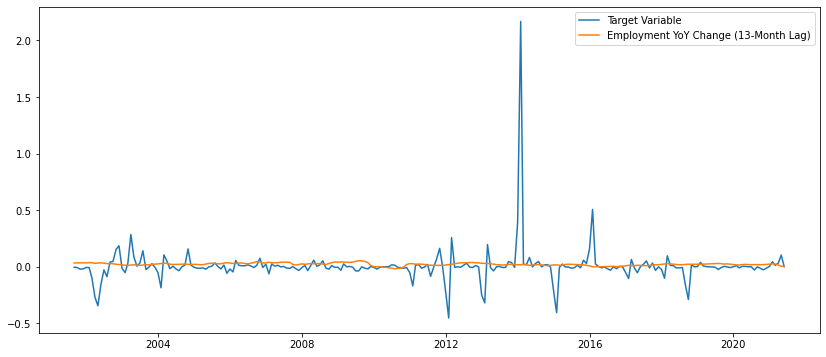

In [36]:
plt.figure(figsize = (14, 6))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.cpi_yoy_ch_13, label = 'Employment YoY Change (13-Month Lag)')
plt.legend()

Notes:
- we would include highest and lowest correlation features
- in 1-2 months ahead, soc and unemp have large correlation
- around half year: cpi has large correlation
- 10-plus periods: unemp and emp 

## Shift target variables for 1, 3, 6, 12, 18 months

In [37]:
df_1 = df
df_1 = df_1.reset_index()
df_1['target'] = df_1.target.shift(-1)
df_1['date'] = df_1.date.shift(-1)
df_1 = df_1.dropna()
df_1 = df_1.set_index('date')
df_1['month'] = df_1.index.month
df_1

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,-0.007256,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,10
2001-11-01,-0.022500,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,11
2001-12-01,-0.020024,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,12
2002-01-01,-0.007431,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1
2002-02-01,-0.008379,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.042618,0.002559,0.013515,262.231,-0.009685,0.013317,82.6,-0.035019,-0.007483,3341.0,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,2
2021-03-01,0.011291,0.003534,0.016480,263.161,0.003619,0.007238,82.9,-0.018287,0.006705,3281.0,...,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,3
2021-04-01,0.030445,0.006163,0.025696,264.793,-0.004848,-0.003636,82.5,-0.001221,0.031431,3277.0,...,4989.0,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4


In [38]:
df_3 = df
df_3 = df_3.reset_index()
df_3['target'] = df_3.target.shift(-3)
df_3['date'] = df_3.date.shift(-3)
df_3 = df_3.dropna()
df_3 = df_3.set_index('date')
df_3['month'] = df_3.index.month
df_3

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-12-01,-0.020024,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,12
2002-01-01,-0.007431,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1
2002-02-01,-0.008379,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,2
2002-03-01,-0.099550,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,3
2002-04-01,-0.270032,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.042618,0.001782,0.011260,260.927,0.008424,0.007220,83.1,0.030285,-0.066745,3401.0,...,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,2
2021-03-01,0.011291,0.002420,0.012835,261.560,0.003597,0.007194,83.4,0.016484,-0.021689,3458.0,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,3
2021-04-01,0.030445,0.002559,0.013515,262.231,-0.009685,0.013317,82.6,-0.035019,-0.007483,3341.0,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4


In [39]:
df_6 = df
df_6 = df_6.reset_index()
df_6['target'] = df_6.target.shift(-6)
df_6['date'] = df_6.date.shift(-6)
df_6 = df_6.dropna()
df_6 = df_6.set_index('date')
df_6['month'] = df_6.index.month
df_6

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2002-03-01,-0.099550,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,3
2002-04-01,-0.270032,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,4
2002-05-01,-0.346031,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,5
2002-06-01,-0.156167,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,6
2002-07-01,-0.029472,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.042618,0.003495,0.013075,259.511,0.002410,0.006024,83.0,0.005871,-0.168950,3066.0,...,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,2
2021-03-01,0.011291,0.002452,0.013904,260.149,0.002404,0.006010,83.2,0.026358,-0.142903,3149.0,...,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,3
2021-04-01,0.030445,0.001202,0.011806,260.462,-0.009709,0.010922,82.4,0.045179,-0.106731,3298.0,...,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4


In [40]:
df_12 = df
df_12 = df_12.reset_index()
df_12['target'] = df_12.target.shift(-12)
df_12['date'] = df_12.date.shift(-12)
df_12 = df_12.dropna()
df_12 = df_12.set_index('date')
df_12['month'] = df_12.index.month
df_12

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2002-09-01,0.040499,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,9
2002-10-01,0.045425,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,10
2002-11-01,0.151730,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,11
2002-12-01,0.184430,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,12
2003-01-01,-0.014347,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.042618,0.000529,0.022622,258.824,0.009721,-0.008505,82.3,-0.032832,-0.061369,3259.0,...,4675.0,4670.0,4672.0,4682.0,4636.0,4532.0,4372.0,4262.0,4203.0,2
2021-03-01,0.011291,-0.003237,0.014892,257.989,0.006039,-0.002415,82.8,-0.026780,-0.107435,3174.0,...,4688.0,4675.0,4670.0,4672.0,4682.0,4636.0,4532.0,4372.0,4262.0,3
2021-04-01,0.030445,-0.007014,0.003380,256.192,-0.010989,-0.009768,81.9,-0.008900,-0.149078,3146.0,...,4691.0,4688.0,4675.0,4670.0,4672.0,4682.0,4636.0,4532.0,4372.0,4


In [41]:
df_18 = df
df_18 = df_18.reset_index()
df_18['target'] = df_18.target.shift(-18)
df_18['date'] = df_18.date.shift(-18)
df_18 = df_18.dropna()
df_18 = df_18.set_index('date')
df_18['month'] = df_18.index.month
df_18

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2003-03-01,0.028986,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,3
2003-04-01,0.284133,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,4
2003-05-01,0.086355,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,5
2003-06-01,0.004287,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,6
2003-07-01,0.030822,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.042618,0.000754,0.017113,256.118,-0.003636,0.001212,82.5,-0.005859,0.035435,3584.0,...,4372.0,4262.0,4203.0,4194.0,4156.0,4090.0,3995.0,3958.0,3977.0,2
2021-03-01,0.011291,0.001614,0.016953,256.532,0.002418,0.003628,82.7,0.004168,0.035565,3599.0,...,4532.0,4372.0,4262.0,4203.0,4194.0,4156.0,4090.0,3995.0,3958.0,3
2021-04-01,0.030445,0.003322,0.017437,257.387,-0.014724,-0.011043,81.5,0.013973,0.043288,3650.0,...,4636.0,4532.0,4372.0,4262.0,4203.0,4194.0,4156.0,4090.0,3995.0,4


# Model

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from PlotForecast import plot_forecast

## SARIMA Model - 1 month

In [43]:
var_corr_1 = (df_1.corr().sort_values('target'))
var_corr_1.head()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_9,-0.125837,0.018511,0.142204,-0.295389,-0.030602,-0.120108,0.233079,0.005182,-0.042516,-0.338650,...,-0.324362,-0.323818,-0.322748,-0.321019,-0.319135,-0.318104,-0.318682,-0.320701,-0.323580,0.026735
ppi_w_yoy_ch_13,-0.111746,-0.107259,-0.399642,0.619329,0.118067,0.462065,-0.548812,-0.157879,-0.291433,0.637340,...,0.566481,0.569781,0.572951,0.575085,0.575453,0.574356,0.572758,0.571309,0.570097,-0.015102
cpi_yoy_ch_10,-0.104975,0.024659,0.067023,-0.298277,-0.018673,-0.113251,0.241654,-0.022119,-0.090016,-0.344065,...,-0.326262,-0.326185,-0.325596,-0.324454,-0.322695,-0.320838,-0.319816,-0.320366,-0.322377,0.020707
cpi_yoy_ch_8,-0.101707,0.010230,0.216256,-0.291827,-0.012030,-0.113618,0.225308,-0.007931,0.009113,-0.334253,...,-0.321319,-0.320313,-0.318704,-0.316928,-0.315912,-0.316488,-0.318499,-0.321358,-0.324461,0.023958
cpi_mom_ch_10,-0.089394,0.073769,0.374487,-0.095398,0.043699,-0.071164,0.069481,-0.063294,0.106958,-0.103473,...,-0.105107,-0.102272,-0.101476,-0.102133,-0.103539,-0.106234,-0.110471,-0.115645,-0.119710,-0.094410


In [44]:
var_corr_1.tail()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
ppi_w_yoy_ch_3,0.113996,0.019588,-0.121159,0.694707,0.037430,0.785329,-0.692384,-0.068238,-0.078240,0.677701,...,0.602070,0.600041,0.597543,0.594761,0.592110,0.589826,0.587674,0.585563,0.583343,-0.001026
ppi_w_yoy_ch,0.124246,-0.060336,-0.141000,0.684642,0.260188,1.000000,-0.661280,-0.041146,-0.070011,0.666035,...,0.589661,0.587850,0.585995,0.584041,0.581790,0.579533,0.577407,0.575656,0.574492,0.006402
ppi_w_yoy_ch_1,0.125677,-0.044074,-0.149770,0.688860,0.014924,0.917994,-0.676673,-0.025226,-0.066794,0.671401,...,0.594717,0.592485,0.590539,0.588402,0.586125,0.583783,0.581531,0.579477,0.577800,0.002734
imp_mom_ch_9,0.138942,-0.009480,0.233084,-0.170077,0.043385,-0.021944,0.046018,-0.232011,0.474017,-0.127810,...,-0.213987,-0.215066,-0.215481,-0.217935,-0.222836,-0.229497,-0.236309,-0.242653,-0.248030,0.021824
target,1.000000,0.031953,0.014158,0.034789,0.013354,0.124246,-0.043055,0.073747,0.089049,0.039943,...,0.025760,0.023659,0.022263,0.021637,0.021654,0.021995,0.022310,0.023121,0.024681,-0.017837


In [45]:
X1 = df_1.drop(['target'],axis = 1)
X1.head()

,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,exp_mom_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,0.003930,0.025267,178.1,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,-0.009443,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,10
2001-11-01,-0.002815,0.020833,177.6,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,-0.012428,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,11
2001-12-01,-0.000563,0.018592,177.5,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,-0.008679,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,12
2002-01-01,-0.000564,0.015784,177.4,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,-0.003872,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1
2002-02-01,0.001688,0.011818,177.7,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,-0.000969,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,2


In [46]:
y1 = df_1.target
y1

date
2001-10-01   -0.007256
2001-11-01   -0.022500
2001-12-01   -0.020024
2002-01-01   -0.007431
2002-02-01   -0.008379
                ...   
2021-02-01    0.042618
2021-03-01    0.011291
2021-04-01    0.030445
2021-05-01    0.101845
2021-06-01   -0.001181
Name: target, Length: 237, dtype: float64

In [47]:
feature_names = X1.columns.values
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe = RFE(LinearRegression(), 
          n_features_to_select=5, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X1,y1)
feature_names[rfe.get_support()]

array(['cpi_mom_ch', 'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13',
       'ppi_w_yoy_ch_1', 'ppi_w_yoy_ch_2'], dtype=object)

In [48]:
model_exvar = ['cpi_mom_ch', 'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13',
       'ppi_w_yoy_ch_1', 'ppi_w_yoy_ch_2']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [49]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  184
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                  35.227
Date:                                 Mon, 30 Aug 2021   AIC                            -52.454
Time:                                         19:52:15   BIC                            -24.127
Sample:                                              0   HQIC                           -40.961
                                                 - 184                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0026     13.949     -0.000      1.000     -27.343      27

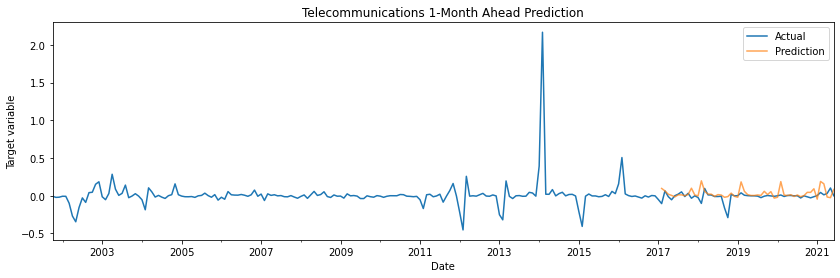

In [50]:
sarimax_model = SARIMAX(y_train, 
                order = (1,0,0), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sarimax_mod_fit = sarimax_model.fit()

sarimax_pred = sarimax_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar_pred = sarimax_pred.predicted_mean
sar_pred_ci = sarimax_pred.conf_int()
ax = df_1.target.plot(label='Actual')
sar_pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 1-Month Ahead Prediction')
plt.legend()
plt.show()


In [51]:
def forecast_accuracy(forecast, actual):
    '''
    These are some accuracy metrics we use to compare how accurate our forecast values are.
    '''
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax                
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [52]:
metrics1 = forecast_accuracy(y_test, sar_pred)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 2.53203
MAE: 0.05551


In [53]:
sar1_pred = sarimax_pred.predicted_mean
sar1_pred_ci = sarimax_pred.conf_int()

pred_results1 = pd.DataFrame(df_1.target).join(sar1_pred).join(sar1_pred_ci)
pred_results1

,target,predicted_mean,lower target,upper target
date,,,,
2001-10-01,-0.007256,NaN,NaN,NaN
2001-11-01,-0.022500,NaN,NaN,NaN
2001-12-01,-0.020024,NaN,NaN,NaN
2002-01-01,-0.007431,NaN,NaN,NaN
2002-02-01,-0.008379,NaN,NaN,NaN
...,...,...,...,...
2021-02-01,0.042618,0.188947,-0.194069,0.571963
2021-03-01,0.011291,0.157420,-0.225703,0.540542
2021-04-01,0.030445,-0.017682,-0.400808,0.365444


* Index converted to datetime. Please verify example below.
from 2001-10-01 00:00:00 to 2001-10-01 00:00:00

* Dropping duplicate index values. Keeping last.



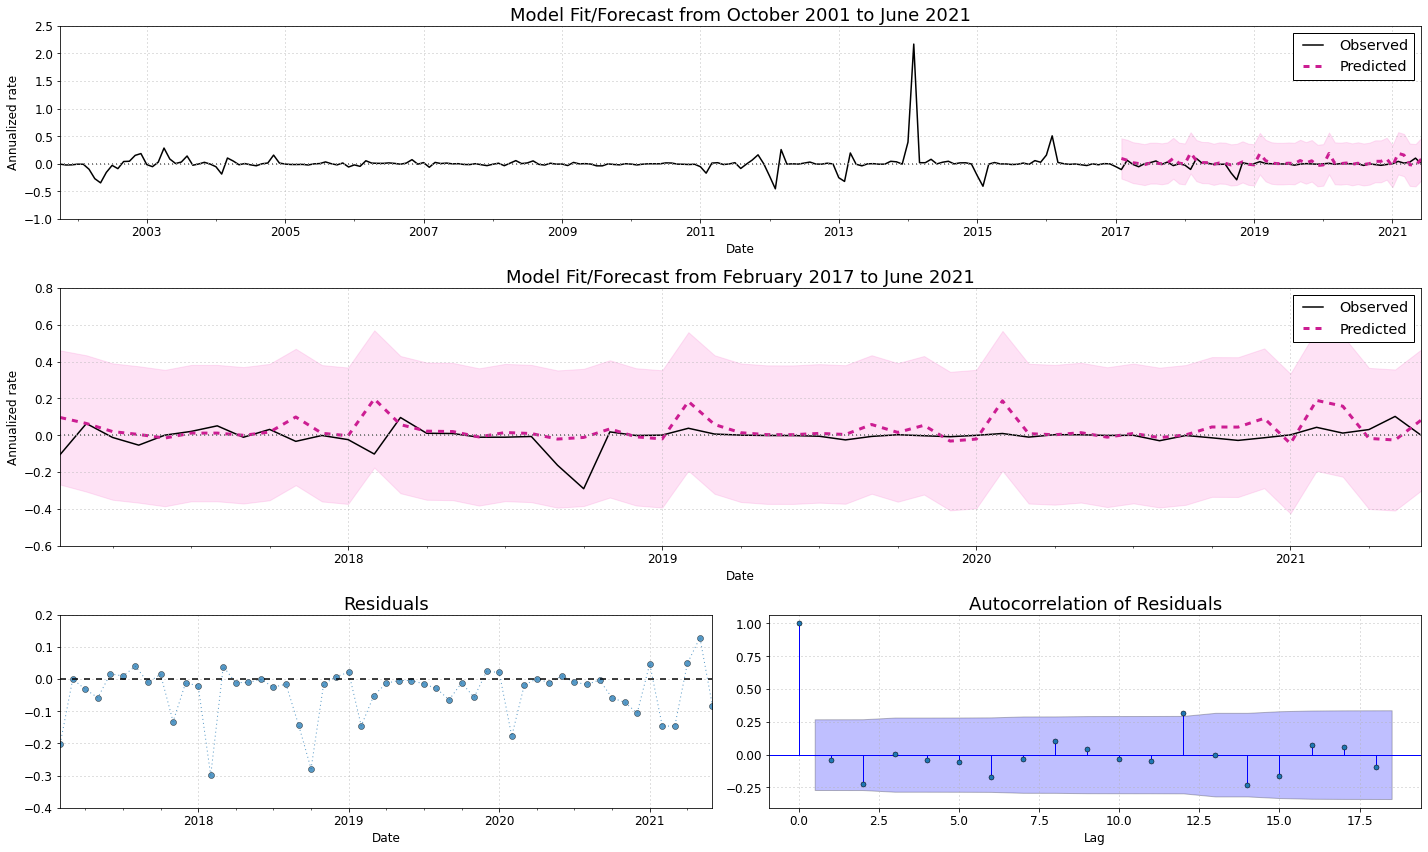

In [54]:
f = plot_forecast(data=pred_results1, data_index_col=0, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 3 month

In [55]:
var_corr_3 = (df_3.corr().sort_values('target'))
var_corr_3.head()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_7,-0.125357,0.007477,0.309794,-0.282846,0.005917,-0.107667,0.210034,-0.048734,0.067576,-0.325409,...,-0.314092,-0.312365,-0.310461,-0.309413,-0.309996,-0.312036,-0.314950,-0.318122,-0.321456,0.014939
ppi_w_yoy_ch_11,-0.112550,-0.182144,-0.378785,0.624711,0.184090,0.445468,-0.570281,-0.177809,-0.247312,0.636708,...,0.571176,0.573325,0.573696,0.572590,0.570980,0.569519,0.568298,0.567086,0.565711,-0.009174
cpi_yoy_ch_8,-0.104402,0.019052,0.229918,-0.287524,-0.008900,-0.109073,0.221978,-0.004893,0.010051,-0.331299,...,-0.317847,-0.316710,-0.314934,-0.313052,-0.312015,-0.312569,-0.314602,-0.317521,-0.320701,0.010142
cpi_yoy_ch_6,-0.101146,-0.020136,0.391891,-0.278207,-0.001199,-0.111200,0.197908,-0.104388,0.132030,-0.317981,...,-0.309646,-0.307867,-0.306840,-0.307419,-0.309454,-0.312347,-0.315490,-0.318804,-0.322182,0.011905
cpi_mom_ch_8,-0.089256,-0.064332,0.338816,-0.095879,0.037207,-0.057944,0.063670,-0.034040,0.191713,-0.099898,...,-0.100948,-0.101612,-0.103028,-0.105742,-0.110006,-0.115215,-0.119306,-0.121831,-0.123345,-0.096217


In [56]:
var_corr_3.tail()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
ppi_w_yoy_ch,0.104939,-0.078265,-0.162095,0.681206,0.255848,1.000000,-0.658587,-0.047496,-0.072025,0.663139,...,0.584849,0.582894,0.580883,0.578724,0.576359,0.573907,0.571707,0.569924,0.568777,0.023508
imp_mom_ch_6,0.112574,-0.064249,0.297330,-0.165391,-0.027639,-0.054182,0.047500,0.188335,0.501456,-0.113841,...,-0.207988,-0.215237,-0.223190,-0.230213,-0.235628,-0.240247,-0.243904,-0.246300,-0.246512,-0.050380
ppi_w_yoy_ch_1,0.113421,-0.058252,-0.169810,0.687145,0.010201,0.918835,-0.674787,-0.029749,-0.068949,0.669146,...,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192,0.012317
imp_mom_ch_7,0.138658,-0.028934,0.294774,-0.177568,-0.037054,-0.054115,0.047860,0.090112,0.506372,-0.115685,...,-0.221157,-0.223612,-0.228546,-0.235259,-0.242122,-0.248515,-0.253932,-0.258243,-0.260933,0.025778
target,1.000000,0.020414,-0.047959,0.030606,-0.018146,0.104939,-0.039454,0.056474,0.038361,0.033704,...,0.021142,0.020515,0.020533,0.020875,0.021193,0.022008,0.023578,0.024989,0.025800,-0.016699


In [57]:
X3 = df_3.drop(['target'],axis = 1)
#X3.head()

In [58]:
y3 = df_3.target
#y3

In [59]:
feature_names = X3.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X3,y3)
feature_names[rfe.get_support()]

array(['cpi_mom_ch', 'cpi_yoy_ch', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'cpi_mom_ch_1', 'cpi_mom_ch_12', 'cpi_mom_ch_13', 'cpi_yoy_ch_1',
       'cpi_yoy_ch_2', 'ppi_w_mom_ch_12'], dtype=object)

In [60]:
model_exvar = ['cpi_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_3.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_3.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [61]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  182
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                  29.951
Date:                                 Mon, 30 Aug 2021   AIC                            -49.902
Time:                                         19:53:17   BIC                            -34.223
Sample:                                              0   HQIC                           -43.540
                                                 - 182                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9462     15.016      0.063      0.950     -28.485      30

In [62]:
sar3_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sar3_mod_fit = sar3_model.fit()

sar3_pred = sar3_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

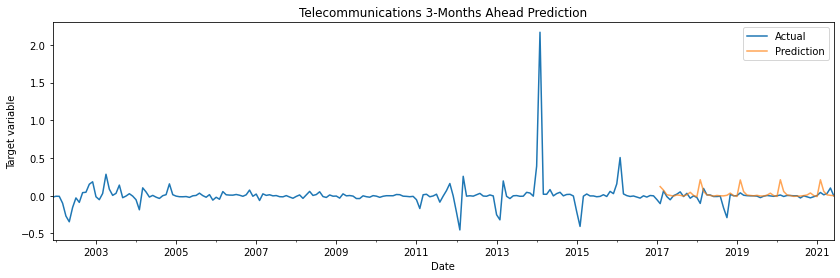

In [63]:
sar3_pred_mean = sar3_pred.predicted_mean
sar3_pred_ci = sar3_pred.conf_int()
ax = df_3.target.plot(label='Actual')
sar3_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 3-Months Ahead Prediction')
plt.legend()
plt.show()

In [64]:
metrics1 = forecast_accuracy(y_test, sar3_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 4.78929
MAE: 0.04663


In [65]:
pred_results3 = pd.DataFrame(df_3.target).join(sar3_pred_mean).join(sar3_pred_ci)
pred_results3

,target,predicted_mean,lower target,upper target
date,,,,
2001-12-01,-0.020024,NaN,NaN,NaN
2002-01-01,-0.007431,NaN,NaN,NaN
2002-02-01,-0.008379,NaN,NaN,NaN
2002-03-01,-0.099550,NaN,NaN,NaN
2002-04-01,-0.270032,NaN,NaN,NaN
...,...,...,...,...
2021-02-01,0.042618,0.210634,-0.184790,0.606059
2021-03-01,0.011291,0.057461,-0.338100,0.453022
2021-04-01,0.030445,0.010777,-0.384783,0.406338


* Index converted to datetime. Please verify example below.
from 2001-12-01 00:00:00 to 2001-12-01 00:00:00

* Dropping duplicate index values. Keeping last.



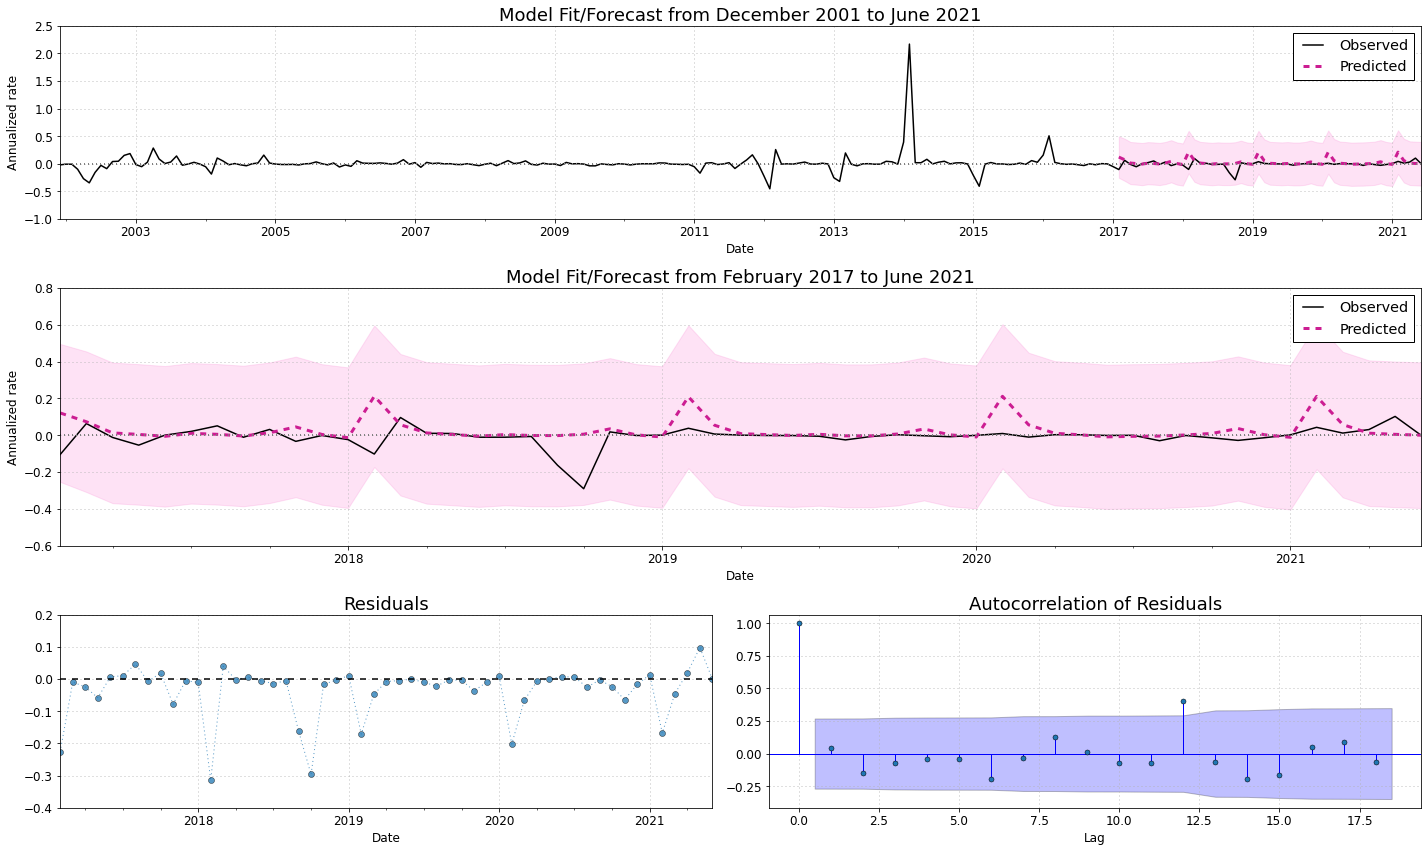

In [66]:
f = plot_forecast(data=pred_results3, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 6 month

In [67]:
var_corr_6 = (df_6.corr().sort_values('target'))
var_corr_6.head()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_4,-0.124787,-0.089947,0.578567,-0.264830,-0.010430,-0.105160,0.177174,-0.146223,0.282213,-0.295437,...,-0.299052,-0.299668,-0.301742,-0.304693,-0.307905,-0.311284,-0.314733,-0.318502,-0.323049,0.017383
ppi_w_yoy_ch_8,-0.113206,-0.251018,-0.293233,0.642734,0.187047,0.540312,-0.612926,-0.127668,-0.180919,0.644920,...,0.575184,0.573512,0.572024,0.570797,0.569582,0.568202,0.566251,0.563818,0.561089,-0.005109
cpi_yoy_ch_5,-0.103728,-0.050183,0.480872,-0.269277,-0.002423,-0.102325,0.186057,-0.155768,0.201781,-0.305965,...,-0.301335,-0.300302,-0.300862,-0.302918,-0.305876,-0.309105,-0.312504,-0.315977,-0.319774,0.013330
cpi_yoy_ch_3,-0.100563,-0.153536,0.682623,-0.256918,0.006381,-0.107636,0.165489,-0.111275,0.359283,-0.282899,...,-0.296819,-0.298924,-0.301869,-0.305053,-0.308408,-0.311831,-0.315563,-0.320070,-0.325486,0.020162
cpi_mom_ch_5,-0.088832,-0.063429,0.343568,-0.083749,-0.010177,-0.016898,0.043660,-0.045206,0.229304,-0.082149,...,-0.100850,-0.105157,-0.110428,-0.114573,-0.117132,-0.118669,-0.120116,-0.120743,-0.120454,-0.108054


In [68]:
var_corr_6.tail()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
ppi_w_mom_ch_2,0.091028,-0.016181,-0.051316,0.153805,-0.056040,0.227713,-0.145236,0.058128,-0.007668,0.152044,...,0.132649,0.131981,0.131935,0.131708,0.131125,0.129599,0.128389,0.127721,0.128278,-0.023149
ppi_w_mom_ch_6,0.097792,0.064124,-0.012411,0.180543,-0.106976,0.216852,-0.198616,-0.000671,-0.006525,0.173023,...,0.147320,0.145942,0.144312,0.142876,0.141975,0.141683,0.141969,0.141920,0.141250,0.000469
imp_mom_ch_3,0.112410,0.165553,0.297948,-0.168109,0.030151,-0.057717,0.057640,-0.139594,0.532116,-0.117721,...,-0.234376,-0.239832,-0.244497,-0.248198,-0.250627,-0.250846,-0.248273,-0.243511,-0.237701,-0.050197
imp_mom_ch_4,0.138408,0.041784,0.316261,-0.180127,-0.008550,-0.057204,0.063210,-0.138652,0.526630,-0.133346,...,-0.241068,-0.247981,-0.254439,-0.259921,-0.264287,-0.267011,-0.267478,-0.265291,-0.260843,0.026024
target,1.000000,0.036559,-0.032654,0.030990,0.019581,0.077880,-0.038336,-0.039597,0.012046,0.029685,...,0.019431,0.019754,0.020578,0.022162,0.023585,0.024404,0.024361,0.024518,0.025203,-0.016876


In [69]:
X6 = df_6.drop(['target'],axis = 1)
#X6.head()

In [70]:
y6 = df_6.target
#y6

In [71]:
feature_names = X6.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=5, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X6,y6)
feature_names[rfe.get_support()]

array(['ppi_w_mom_ch', 'cpi_mom_ch_1', 'cpi_mom_ch_13', 'cpi_yoy_ch_1',
       'cpi_yoy_ch_2'], dtype=object)

In [72]:
model_exvar = ['ppi_w_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_6.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_6.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [73]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                  27.753
Date:                                 Mon, 30 Aug 2021   AIC                            -45.506
Time:                                         19:54:06   BIC                            -29.916
Sample:                                              0   HQIC                           -39.178
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0435      5.835      0.007      0.994     -11.393      11

In [106]:
sar6_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sar6_mod_fit = sar6_model.fit()

sar6_pred = sar6_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

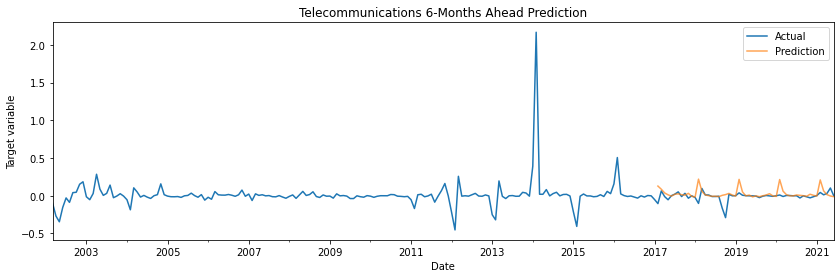

In [107]:
sar6_pred_mean = sar6_pred.predicted_mean
sar6_pred_ci = sar6_pred.conf_int()
ax = df_6.target.plot(label='Actual')
sar6_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 6-Months Ahead Prediction')
plt.legend()
plt.show()


In [108]:
metrics1 = forecast_accuracy(y_test, sar6_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 6.54602
MAE: 0.04731


In [77]:
pred_results6 = pd.DataFrame(df_6.target).join(sar6_pred_mean).join(sar6_pred_ci)
pred_results6

,target,predicted_mean,lower target,upper target
date,,,,
2002-03-01,-0.099550,NaN,NaN,NaN
2002-04-01,-0.270032,NaN,NaN,NaN
2002-05-01,-0.346031,NaN,NaN,NaN
2002-06-01,-0.156167,NaN,NaN,NaN
2002-07-01,-0.029472,NaN,NaN,NaN
...,...,...,...,...
2021-02-01,0.042618,0.134522,-0.259941,0.528985
2021-03-01,0.011291,0.047900,-0.346474,0.442275
2021-04-01,0.030445,0.010985,-0.383389,0.405360


* Index converted to datetime. Please verify example below.
from 2002-03-01 00:00:00 to 2002-03-01 00:00:00

* Dropping duplicate index values. Keeping last.



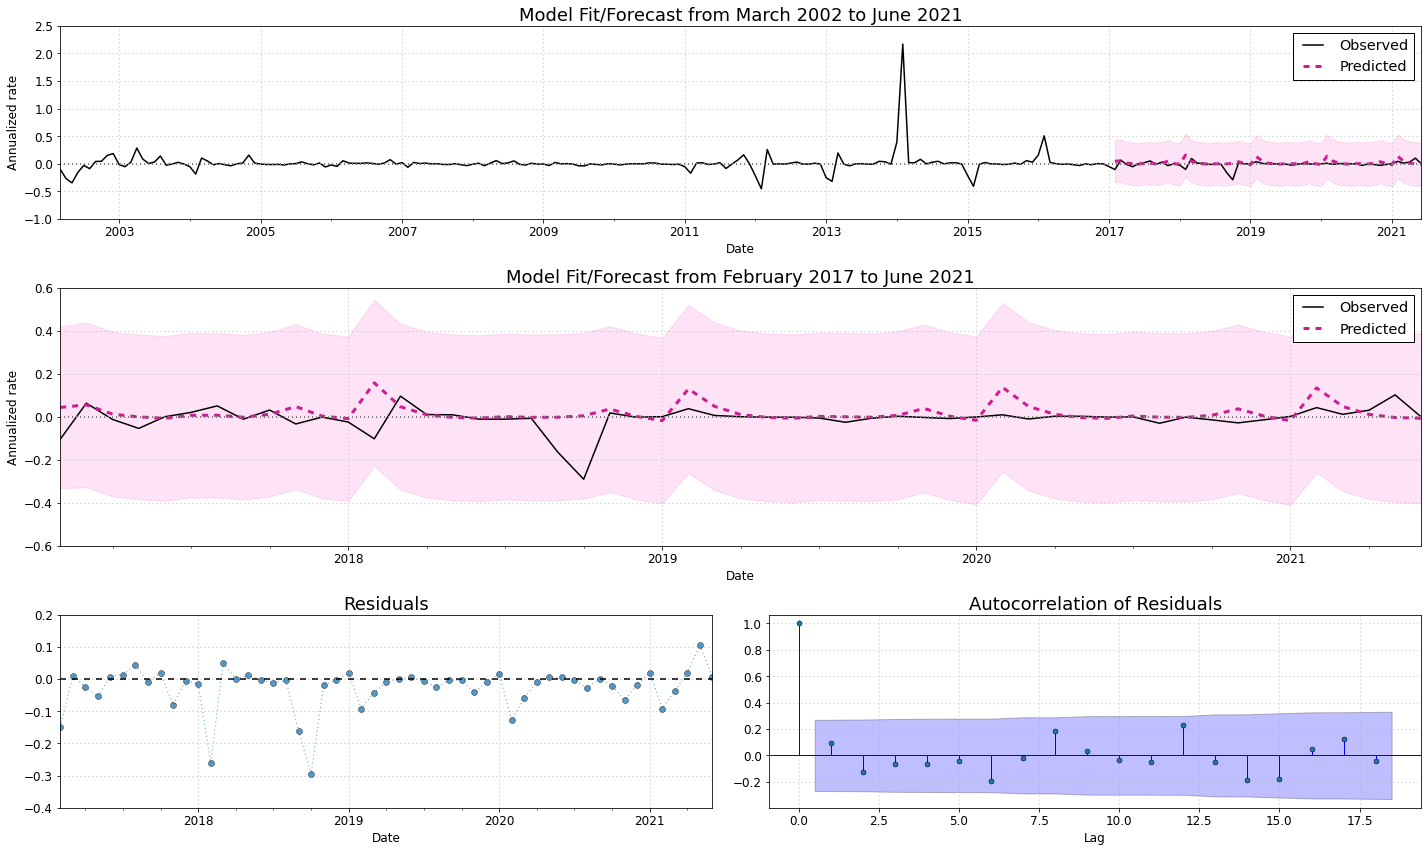

In [78]:
f = plot_forecast(data=pred_results6, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 12 month

In [79]:
var_corr_12 = (df_12.corr().sort_values('target'))
var_corr_12.head()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
ppi_w_yoy_ch_2,-0.113828,-0.031789,-0.148615,0.676081,0.004384,0.846895,-0.675949,-0.044191,-0.018299,0.661658,...,0.574672,0.572218,0.569450,0.566698,0.564093,0.561606,0.559204,0.556806,0.554738,0.000248
imp_yoy_ch_6,-0.109972,0.029216,0.368667,-0.126588,0.007257,0.113499,-0.097879,0.015331,0.497007,-0.131732,...,-0.233121,-0.234519,-0.237091,-0.240919,-0.245882,-0.251806,-0.258341,-0.264989,-0.271143,0.004789
imp_yoy_ch_5,-0.107962,0.034047,0.420935,-0.146619,0.017390,0.099621,-0.076788,0.021894,0.586523,-0.144190,...,-0.251675,-0.254327,-0.258238,-0.263276,-0.269239,-0.275834,-0.282555,-0.288804,-0.294060,0.005385
ppi_w_mom_ch_2,-0.102241,-0.023064,-0.045686,0.148637,-0.070164,0.229495,-0.141325,0.055928,0.027149,0.151747,...,0.123450,0.122970,0.123281,0.123240,0.122528,0.120821,0.119536,0.118884,0.119462,-0.078217
imp_yoy_ch_7,-0.099981,0.044697,0.321512,-0.108879,-0.007496,0.120462,-0.118895,-0.003374,0.412467,-0.120669,...,-0.219082,-0.219775,-0.221192,-0.223749,-0.227544,-0.232484,-0.238382,-0.244899,-0.251535,-0.002738


In [80]:
var_corr_12.tail()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_12,0.081199,-0.010171,-0.063015,-0.292344,-0.028196,-0.102056,0.245115,-0.044129,-0.174024,-0.350824,...,-0.312123,-0.315201,-0.318734,-0.321916,-0.323726,-0.323542,-0.321661,-0.319354,-0.318124,0.011610
exp_mom_ch_11,0.085715,-0.102949,0.211959,0.083412,-0.005859,0.125019,-0.119973,-0.074049,0.121403,0.054961,...,0.056704,0.058458,0.062501,0.067536,0.069556,0.061697,0.042965,0.018376,-0.000429,-0.096487
exp_mom_ch_12,0.113321,-0.173221,0.106793,0.082883,0.002332,0.100347,-0.121113,-0.049158,0.064432,0.054222,...,0.062377,0.063106,0.065043,0.069249,0.074422,0.076521,0.068696,0.049937,0.025291,-0.011584
exp_mom_ch_13,0.124474,-0.192251,-0.011453,0.074913,0.036532,0.102183,-0.114475,-0.124809,-0.000775,0.047747,...,0.058995,0.059538,0.060246,0.062171,0.066383,0.071577,0.073672,0.065771,0.046842,0.031463
target,1.000000,0.047799,-0.053649,-0.016230,0.066551,-0.067275,0.023821,-0.026783,-0.080851,-0.022939,...,-0.008433,-0.008307,-0.007649,-0.006704,-0.006568,-0.007272,-0.008913,-0.011331,-0.014453,-0.028628


In [81]:
X12 = df_12.drop(['target'],axis = 1)
#X12.head()

In [82]:
y12 = df_12.target
#y12

In [83]:
feature_names = X12.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X12,y12)
feature_names[rfe.get_support()]

array(['cpi_mom_ch', 'cpi_yoy_ch', 'cpi_mom_ch_1', 'cpi_mom_ch_12',
       'cpi_mom_ch_13', 'cpi_yoy_ch_1', 'cpi_yoy_ch_2', 'exp_mom_ch_13',
       'exp_yoy_ch_1', 'exp_yoy_ch_2'], dtype=object)

In [84]:
model_exvar = ['cpi_mom_ch','exp_mom_ch_13']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [85]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  173
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                  27.687
Date:                            Mon, 30 Aug 2021   AIC                            -43.375
Time:                                    19:56:12   BIC                            -24.886
Sample:                                         0   HQIC                           -35.868
                                            - 173                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.9802     12.865      0.620      0.535     -17.234      33.195
x2             2.4530      2.980   

In [86]:
sar12_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (1,1,1,12)
                , exog = x_train
                )

sar12_mod_fit = sar12_model.fit()

sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

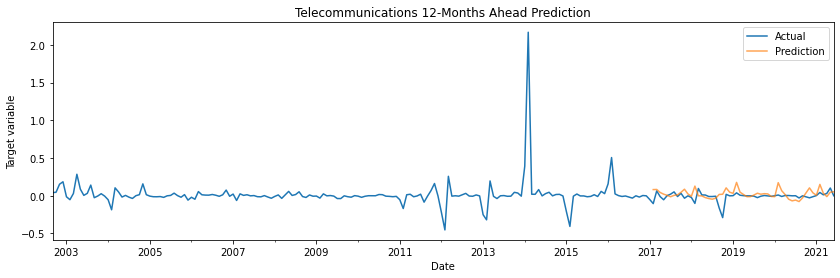

In [87]:
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 12-Months Ahead Prediction')
plt.legend()
plt.show()

In [88]:
metrics1 = forecast_accuracy(y_test, sar12_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 3.41005
MAE: 0.05912


In [89]:
pred_results12 = pd.DataFrame(df_12.target).join(sar12_pred_mean).join(sar12_pred_ci)
pred_results12

,target,predicted_mean,lower target,upper target
date,,,,
2002-09-01,0.040499,NaN,NaN,NaN
2002-10-01,0.045425,NaN,NaN,NaN
2002-11-01,0.151730,NaN,NaN,NaN
2002-12-01,0.184430,NaN,NaN,NaN
2003-01-01,-0.014347,NaN,NaN,NaN
...,...,...,...,...
2021-02-01,0.042618,0.149624,-0.245618,0.544867
2021-03-01,0.011291,0.032156,-0.363203,0.427515
2021-04-01,0.030445,-0.011978,-0.407337,0.383382


* Index converted to datetime. Please verify example below.
from 2002-09-01 00:00:00 to 2002-09-01 00:00:00

* Dropping duplicate index values. Keeping last.



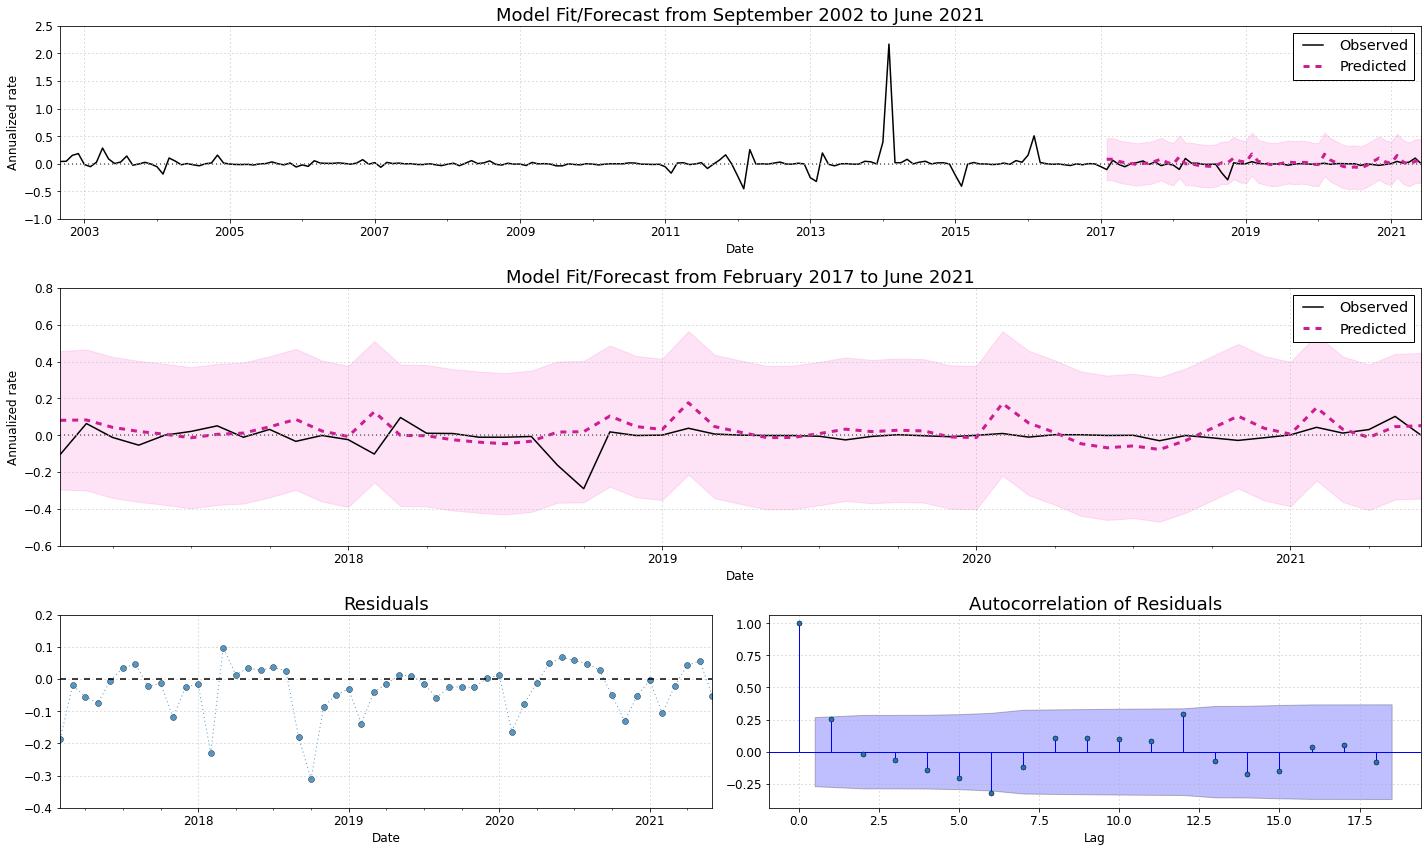

In [90]:
f = plot_forecast(data=pred_results12, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 18 month

In [91]:
var_corr_18 = (df_18.corr().sort_values('target'))
var_corr_18.head()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
imp_yoy_ch,-0.106686,0.134363,0.517266,-0.179375,0.013558,0.027723,-0.053545,0.310568,1.000000,-0.164063,...,-0.290796,-0.297681,-0.304102,-0.309667,-0.314289,-0.318196,-0.321586,-0.324437,-0.326396,0.011964
ppi_w_mom_ch_7,-0.095874,-0.103482,-0.030878,0.194107,0.084364,0.301809,-0.203208,-0.013719,0.001799,0.182993,...,0.162437,0.162476,0.161908,0.160427,0.159333,0.158522,0.158106,0.157939,0.157460,0.016070
imp_yoy_ch_1,-0.094542,0.113687,0.533009,-0.165586,0.016798,0.048319,-0.063700,0.143758,0.968536,-0.151893,...,-0.275439,-0.282234,-0.289187,-0.295655,-0.301248,-0.305908,-0.309848,-0.313260,-0.316117,0.010694
cpi_mom_ch_3,-0.090917,-0.100235,0.336255,-0.059124,0.011108,-0.044801,0.025185,0.136538,0.213493,-0.070527,...,-0.091380,-0.096028,-0.098680,-0.100282,-0.101752,-0.101986,-0.100937,-0.099894,-0.099644,-0.041175
imp_mom_ch_10,-0.088760,-0.000303,0.186913,-0.075741,0.075784,0.076902,-0.016032,-0.060045,0.429251,-0.076385,...,-0.124846,-0.125982,-0.126073,-0.125610,-0.125881,-0.127513,-0.130743,-0.135889,-0.142507,0.022689


In [92]:
var_corr_18.tail()

,target,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
exp_mom_ch_7,0.123038,-0.020361,0.180321,0.102483,0.128539,0.183156,-0.145320,-0.068078,0.302850,0.090486,...,0.083959,0.075896,0.056585,0.031255,0.011791,0.003422,0.004978,0.009641,0.013391,0.031220
cpi_yoy_ch_11,0.124576,0.032402,0.002980,-0.284401,-0.024289,-0.092522,0.232720,-0.073686,-0.185854,-0.340259,...,-0.313896,-0.317860,-0.321468,-0.323619,-0.323550,-0.321411,-0.318509,-0.316543,-0.316632,-0.002690
cpi_yoy_ch_12,0.131180,-0.013172,-0.066863,-0.289077,-0.030435,-0.100275,0.239968,-0.069289,-0.213878,-0.347249,...,-0.312879,-0.316399,-0.320402,-0.324019,-0.326132,-0.325978,-0.323793,-0.320872,-0.318906,-0.000183
cpi_yoy_ch_13,0.134445,0.007636,-0.066644,-0.295071,-0.040243,-0.121809,0.246575,-0.030347,-0.216843,-0.354117,...,-0.315415,-0.318074,-0.321693,-0.325689,-0.329166,-0.331007,-0.330685,-0.328426,-0.325525,0.001288
target,1.000000,0.034569,-0.017984,0.000221,-0.014958,-0.041766,0.008455,-0.063681,-0.106686,-0.003804,...,0.000741,-0.001692,-0.004855,-0.008399,-0.010259,-0.010693,-0.009548,-0.008318,-0.006998,-0.046743


In [93]:
X18 = df_18.drop(['target'],axis = 1)
#X18.head()

In [94]:
y18 = df_18.target
#y18

In [95]:
feature_names = X18.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X18,y18)
feature_names[rfe.get_support()]

array(['cpi_mom_ch_1', 'cpi_mom_ch_2', 'cpi_mom_ch_3', 'cpi_mom_ch_5',
       'cpi_mom_ch_6', 'cpi_mom_ch_8', 'cpi_mom_ch_10', 'cpi_mom_ch_11',
       'cpi_mom_ch_12', 'cpi_yoy_ch_1'], dtype=object)

In [96]:
model_exvar = ['cpi_mom_ch_1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_18.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_18.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [97]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  167
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                  22.493
Date:                                 Mon, 30 Aug 2021   AIC                            -34.987
Time:                                         19:57:01   BIC                            -19.770
Sample:                                              0   HQIC                           -28.806
                                                 - 167                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -4.2589     14.152     -0.301      0.763     -31.997      23

In [98]:
sar18_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sar18_mod_fit = sar18_model.fit()

sar18_pred = sar18_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

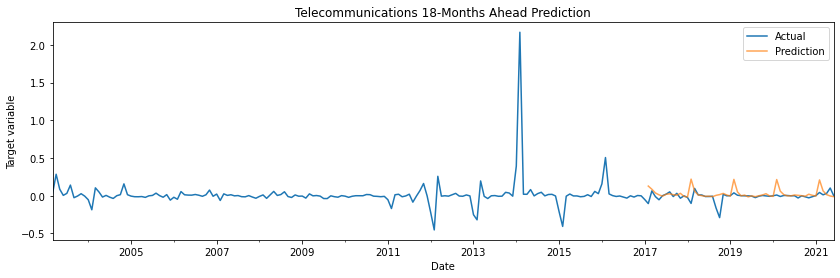

In [99]:
sar18_pred_mean = sar18_pred.predicted_mean
sar18_pred_ci = sar18_pred.conf_int()
ax = df_18.target.plot(label='Actual')
sar18_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 18-Months Ahead Prediction')
plt.legend()
plt.show()

In [100]:
metrics1 = forecast_accuracy(y_test, sar18_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 6.54602
MAE: 0.04731


In [101]:
pred_results18 = pd.DataFrame(df_18.target).join(sar18_pred_mean).join(sar18_pred_ci)
pred_results18

,target,predicted_mean,lower target,upper target
date,,,,
2003-03-01,0.028986,NaN,NaN,NaN
2003-04-01,0.284133,NaN,NaN,NaN
2003-05-01,0.086355,NaN,NaN,NaN
2003-06-01,0.004287,NaN,NaN,NaN
2003-07-01,0.030822,NaN,NaN,NaN
...,...,...,...,...
2021-02-01,0.042618,0.208973,-0.195044,0.612991
2021-03-01,0.011291,0.063591,-0.340492,0.467674
2021-04-01,0.030445,0.014016,-0.390067,0.418099


* Index converted to datetime. Please verify example below.
from 2003-03-01 00:00:00 to 2003-03-01 00:00:00

* Dropping duplicate index values. Keeping last.



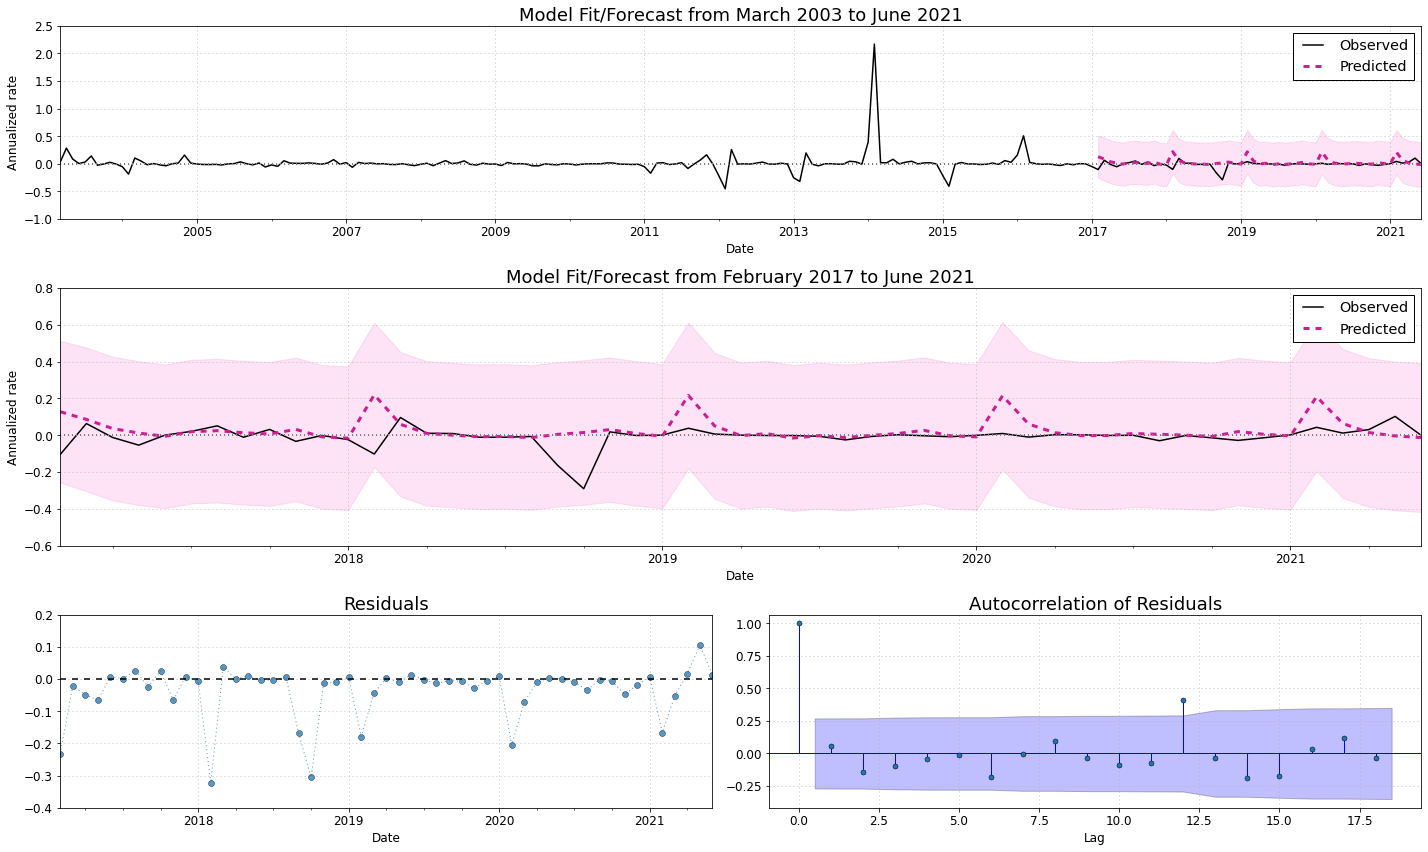

In [102]:
f = plot_forecast(data=pred_results18, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)